# ADA PROJECT - Amazon data

Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

<br>

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

>Features:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


>Features:
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



---

### TO DO LIST

In the followings statements, 'extracted' means filtered with the thema : products/reviews associated to bio/ecology/renewable etc...

- Choose category to focus on : Books ?  / Cinema Movies / Kindle Store / Home Kitchen / Health Personal Care (K) / Tools Home Improvement (K) / Grocery Food  / Tools Home (K)
- Show Proportion of extracted data compared to the full data (of the category)
- Comparison of extracted data between categories (which one contains the most related products/review interest)
- Distribution Price of extracted data (per category) --> Compare between category and with not extracted data in the same category
- Distribution salesRank of extracted data (best per category, mean, proportion of 10% first, 20%first etc...) --> Compare between category and with not extracted data in the same category

- __Keywords__ : How to efficiently implement the selection of related data ? Currently with a list of key words, can use regexp, better writing of keywords etc.. ?

- Associate Metadata with Reviews : __Join__
> - Extract year of 1st review (which will give the publication year of the product -approximately-)
> - Histograms number of extracted products per year 
> - Histograms number of extracted reviews per year
> - Nb of reviews per product per category --> Distribution, compare between categories and with not extracted data to see if reviewers are more inerested/active with our thema products compared to others
> - Helplful note : Compare between categories / Overall
> - Mean rating product : Compare with other products


- __Prediction__
> - Nb of products for following years (Linear Regression)
> - Sentiment Analysis on Reviews (Experiment ?)
> - Prediction overall on price for following years ? (LR)



---
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
from datetime import datetime
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok


%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext
import pyspark.sql.functions as sqlf

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<br>



---
### Data collection and preprocessing

<br>

In this part, we will perform the whole data processing.

To simplify what is presented here, we have decided to perform all these steps for each category in **separate pyton scripts**.

<br>

For each category, we will proceed as follows:
- Import the meta data and reviews that have been downloaded as `json` files
- Extract the relevant and writtable features of meta data
- Save it as a parquet file of the form **`\"category\"_datacleaned`**
- We then do the same with the reviews and save a parquet file of the form **`"category\"_reviews`**
- Next, we **filter the data we have to only keep articles related to ecology/bio/renewable etc...**
- Finally, we join the metadata and review dataset using the product ID, and create a finale parquet file of the form **`\"category\"_review_product_join`**

<br>

Therefore, all you need to do now is execute all the scripts to automatically generate all the parquet files that will be used in tis notebook.

>Note that once these files have been created, we can skip this part to gain a lot of time.

<br>

**Grocery and Gourmet Food**

In [3]:
%run -i "data_collection_grocery_food"
# Run the # Run the data_collection_grocery_food.py file .py file 

**Healthcare**

In [14]:
%run -i "data_collection_healthcare"

**Patio Lawn and Garden**

In [5]:
%run -i "data_collection_lawn_garden"

**Books**

In [ ]:
%run -i "data_collection_books"

**Home and Kitchen**

In [5]:
%run -i "data_collection_home_kitchen"

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
set_stopwords =set(stopwords.words('english'))
punctuation = ['.',',','!','?','(',')','-',"'ll","'s","'","'re",'"']
detokenizer = Detok()
#any(word in word2.lower() for word2 in wordsFiltered for word in keywords)

In [ ]:
def remove_stopwords(text):
    words = word_tokenize(text)
    wordsFiltered = []
    
    for w in words:
        if((w not in set_stopwords) and (w not in punctuation) ):
            wordsFiltered.append(w)
    text = detokenizer.detokenize(wordsFiltered)
    
    return text

In [3]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle ", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

<br>

---
### Loading data
<br>

Now that our scripts have generated the files, let's just fetch the data that will allow us to do our analysis.

<br>

**Grocery and Gourmet Food**

In [4]:
grocery_food_datacleaned = spark.read.parquet("meta_Grocery_and_Gourmet_Food.parquet")
grocery_food_reviews = spark.read.parquet("reviews_Grocery_and_Gourmet_Food.parquet")
grocery_food_review_product_join = spark.read.parquet("Grocery_and_Gourmet_Food.parquet")

In [5]:
grocery_filter_products_bio = grocery_food_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Healthcare**

In [6]:
healthcare_datacleaned = spark.read.parquet("meta_HealthPersonalCare.parquet")
healthcare_reviews = spark.read.parquet("reviews_HealthPersonalCare.parquet")
healthcare_review_product_join = spark.read.parquet("HealthPersonalCare_joined.parquet")

In [7]:
healthcare_filter_products_bio = healthcare_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Patio Lawn and Garden**

In [8]:
patiolawn_garden_datacleaned = spark.read.parquet("meta_PatioLawnGarden.parquet")
patiolawn_garden_reviews = spark.read.parquet("reviews_PatioLawnGarden.parquet")
patiolawn_garden_review_product_join = spark.read.parquet("PatioLawnGarden_joined.parquet")

In [9]:
patiolawn_garden_filter_products_bio = patiolawn_garden_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Books**

In [ ]:
books_datacleaned = spark.read.parquet("meta_Books.parquet")
books_reviews = spark.read.parquet("reviews_Books.parquet")
books_review_product_join = spark.read.parquet("joined_Books.parquet")

In [ ]:
books_filter_products_bio = books_datacleaned.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

**Home and Kitchen**

In [10]:
home_datacleaned = spark.read.parquet("meta_HomeKitchen.parquet")
home_reviews = spark.read.parquet("reviews_Home_and_Kitchen.parquet")
home_review_product_join = spark.read.parquet("Home_and_Kitchen_joined.parquet")

In [11]:
home_filter_eco = home_datacleaned.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

<br>

---
### Analysis

<br>

Now let's start analyzing the data we extracted above.

We will carry out different analyses, and each time apply it to all the categories studied to compare them with each other.

<br>

**1)** First, we will compute and visualize **the proportion of environmentally friendly products in each category**. This will allow us to quickly realize the importance of these products in a category. 

This analysis is also important because we have large differences in quantities between the different categories, which could influence the procaine analyses.

<br>

**2)** Then, we will extract the publication dates of each article in each category to **plot the evolution of the number of eco-friendly products**. With these curves, we will then really be able to observe the evolution of the green trend over time.

Of course, we can a priori suspect that we will obtain increasing curves, but it is interesting to evaluate this growth and compare it from one product category to another.

<br>

**3)** Another analysis that we will carry out focuses on the comments left on each of the products. We will indeed track **the distribution of the number of comments by product**. In this way, we can assess people's interest in environmentally friendly products and compare this interest across categories.

<br>


**4)** Then, we will look at the **average prices of the products in a category, and their evolution over time**. In this way, we will be able to observe the price difference between eco-friendly and other products, and to observe the evolution of this difference over time.

<br>

Useful functions:

In [ ]:
books_filter_products_bio = books_datacleaned.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) )

<br>

#### **1) Proportion of environmentally friendly products in each category**


<br>

**Grocery and Gourmet Food**

In [14]:
print("GROCERY FOOD : Number of products : " + str(grocery_food_datacleaned.rdd.count()) )
print("GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : " + str(grocery_filter_products_bio.count()) )

GROCERY FOOD : Number of products : 145854
GROCERY FOOD : Number of products related to ecology/bio/renewable etc... : 2187


Proportion of extracted data related to ecology/bio/renewable compared to the full data that was available:

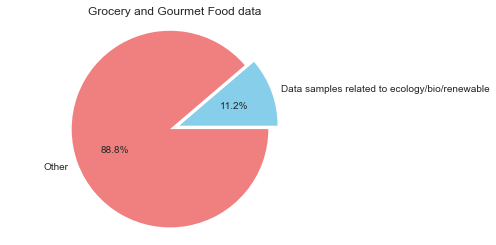

In [7]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([grocery_filter_products_bio.count(), grocery_food_datacleaned.rdd.count()-grocery_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Grocery and Gourmet Food data'); plt.axis('equal'); plt.show()

Let's take a look at one entry that was extracted:

In [14]:
grocery_filter_products_bio.take(1)

[Row(asin='B001EO602S', brand=None, category='Grocery & Gourmet Food', description='The CO2 process delivers a natural, de-caffeinated tea in the purest way possible. Carbon dioxide, acting as a solvent in a super critical state under high-pressure and low temperature, dissolves all active components from natural materials in the leaf. By varying the extraction/separation pressures and temperatures, CO2 makes it possible to selectively extract only the caffeine, leaving the flavor intact. As a solvent, carbon dioxide is non-toxic, odorless, tasteless, germicidal, food-safe and non-combustible and the process does not cause environmental harm.', price=None, salesRank=267957, title='SerendipiTea De-Caff Slim Mint, Chocolate, Vanilla, Rooiboos, Mint &amp; Organic Black Tea, 4-Ounce Boxes (Pack of 2)')]

<br>

**Healthcare**

In [15]:
print("HEALTHCARE : Number of products : " + str(healthcare_datacleaned.rdd.count()) )
print("HEALTHCARE : Number of products related to ecology/bio/renewable etc... : " + str(healthcare_filter_products_bio.count()) )

HEALTHCARE : Number of products : 217977
HEALTHCARE : Number of products related to ecology/bio/renewable etc... : 5390


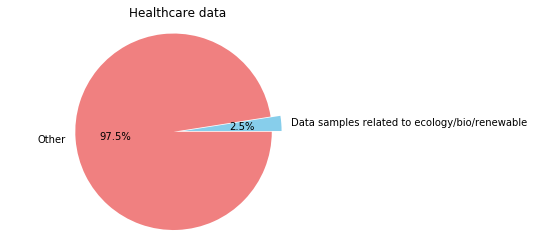

In [16]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([healthcare_filter_products_bio.count(), healthcare_datacleaned.rdd.count()-healthcare_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Healthcare data'); plt.axis('equal'); plt.show()

<br>

**Patio Lawn and Garden**

In [17]:
print("PATIOLAWN - GARDEN : Number of products : " + str(patiolawn_garden_datacleaned.rdd.count()) )
print("PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : " + str(patiolawn_garden_filter_products_bio.count()) )

PATIOLAWN - GARDEN : Number of products : 83455
PATIOLAWN - GARDEN : Number of products related to ecology/bio/renewable etc... : 3026


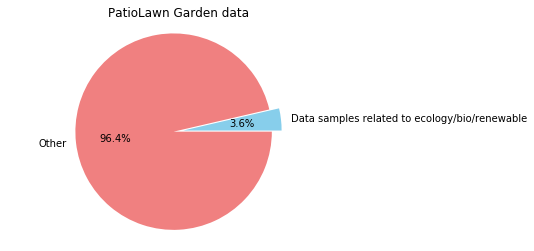

In [18]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([patiolawn_garden_filter_products_bio.count(), patiolawn_garden_datacleaned.rdd.count()-patiolawn_garden_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('PatioLawn Garden data'); plt.axis('equal'); plt.show()

<br>

**Books**

In [22]:
print("BOOKS : Number of products : " + str(books_datacleaned.rdd.count()) )
print("BOOKS : Number of products related to ecology/bio/renewable etc... : " + str(books_filter_products_bio.count()) )

BOOKS : Number of products : 2370585
BOOKS : Number of products related to ecology/bio/renewable etc... : 20723


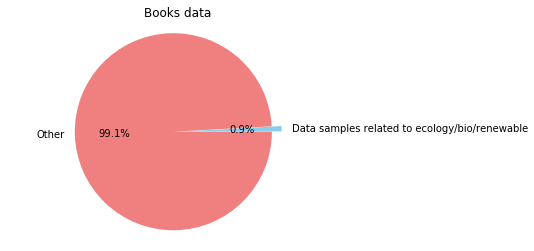

In [23]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([books_filter_products_bio.count(), books_datacleaned.rdd.count()-books_filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Books data'); plt.axis('equal'); plt.show()

**Home and Kitchen**

In [19]:
print("BOOKS : Number of products : " + str(home_datacleaned.rdd.count()) )
print("BOOKS : Number of products related to ecology/bio/renewable etc... : " + str(home_filter_eco.count()) )

BOOKS : Number of products : 336805
BOOKS : Number of products related to ecology/bio/renewable etc... : 7470


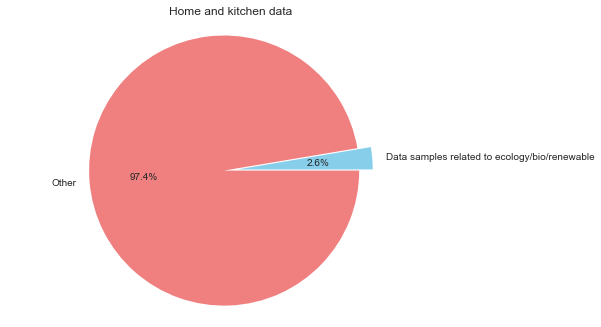

In [623]:
labels = 'Data samples related to ecology/bio/renewable', 'Other'; colors_graph = ['skyblue', 'lightcoral']
plt.pie([home_filter_eco.count(), home_datacleaned.rdd.count()-home_filter_eco.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.title('Home and kitchen data'); plt.axis('equal'); plt.show()

<br>

#### **2) Evolution of the number of eco-friendly products by year.**



Indeed that is something that interest us. The number of eco-friendly item released per year can be a relevant source of information concerning the supply and demand.
But we are also aware not to draw to quick conclusion. We are actually working with Amazon's datasets. Amazon was founded in 1994 and since is in full growth. Although we are expected some special trend or increase of eco-friendly products, we stay aware that there is also a global increase of proposal products.

Futhermore, the awareness in climate change (or the real involvement in it) is something quite recent can be toughly observable in some categories or behavior.

**How we proceed :**
For each category belown, we groupby the product by the id and keep only the minimum time review which correspond to the first review. Then we convert this time in year and assign it as the released year of the product.
We do the process for all filtered eco-friendly products and also for all of them in order to see the difference.


<br>

**Grocery and Gourmet Food**

In [12]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
grocerybio_firstrev = grocery_food_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
grocerybio_firstrev_pd = grocerybio_firstrev.toPandas()
grocerybio_firstrev_pd['Year'] = pd.to_datetime(grocerybio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

# Compute and aggregate first review --> publication year of the product : All products
groceryall_firstrev = grocery_food_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
groceryall_firstrev_pd = groceryall_firstrev.toPandas()
groceryall_firstrev_pd['Year'] = pd.to_datetime(groceryall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [46]:
#Compute Histogram of ecofriendly products publication years
grocerybio_firstrev_index = np.sort(grocerybio_firstrev_pd['Year'].unique())
grocerybio_firstrev_histogram,_ = np.histogram(grocerybio_firstrev_pd['Year'], len(grocerybio_firstrev_index), density=True)

grocerybio_firstrev_serie = pd.Series(grocerybio_firstrev_histogram, index=grocerybio_firstrev_index)*100
grocerybio_firstrev_serie = grocerybio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
groceryeall_firstrev_index = np.sort(groceryall_firstrev_pd['Year'].unique())
groceryall_firstrev_histogram,_ = np.histogram(groceryall_firstrev_pd['Year'], len(groceryeall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
grocery_firstrev_histogram = pd.DataFrame(groceryall_firstrev_histogram, index=groceryeall_firstrev_index, columns=['All Products']) *100  
grocery_firstrev_histogram['Ecofriendly products'] = grocerybio_firstrev_serie
grocery_firstrev_histogram = grocery_firstrev_histogram.fillna(0)

Text(0.5,1,'Histogram : Number of products first published per year (log scale)')

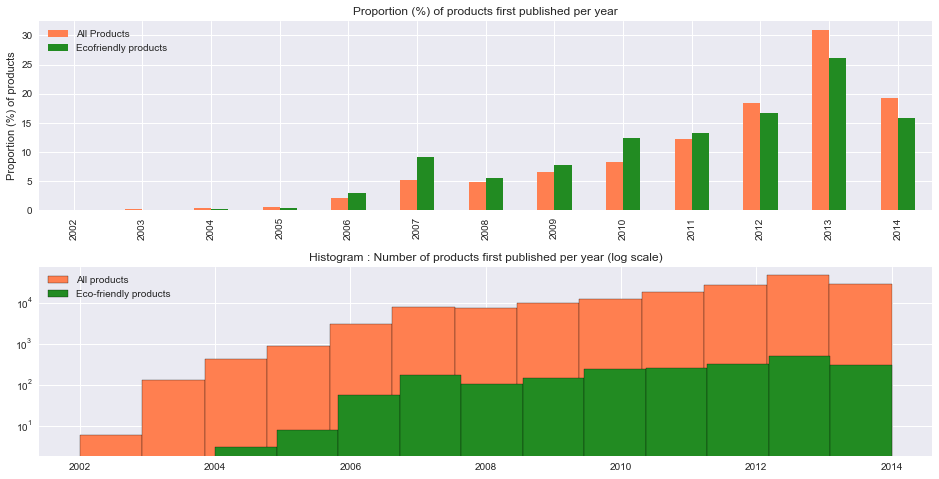

In [50]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,8)

ax1 = grocery_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=axes[0])
ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")

ax2 = groceryall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black',bins=13,ax=axes[1])
grocerybio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black',log=True,bins=11,ax = ax2)


plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')

<br>

**Healthcare**

In [29]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
healthcarebio_firstrev = healthcare_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcarebio_firstrev_pd = healthcarebio_firstrev.toPandas()
healthcarebio_firstrev_pd['Year'] = pd.to_datetime(healthcarebio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcarebio_firstrev_pd = healthcarebio_firstrev_pd.drop('min(unixReviewTime)', axis=1)


# Compute and aggregate first review --> publication year of the product : All products
healthcareall_firstrev = healthcare_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
healthcareall_firstrev_pd = healthcareall_firstrev.toPandas()
healthcareall_firstrev_pd['Year'] = pd.to_datetime(healthcareall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcareall_firstrev_pd = healthcareall_firstrev_pd.drop('min(unixReviewTime)', axis=1)

In [30]:
#Compute Histogram of ecofriendly products publication years
healthcarebio_firstrev_index = np.sort(healthcarebio_firstrev_pd['Year'].unique())
healthcarebio_firstrev_histogram,_ = np.histogram(healthcarebio_firstrev_pd['Year'], len(healthcarebio_firstrev_index), density=True)

healthcarebio_firstrev_serie = pd.Series(healthcarebio_firstrev_histogram, index=healthcarebio_firstrev_index)*100
healthcarebio_firstrev_serie = healthcarebio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
healthcareall_firstrev_index = np.sort(healthcareall_firstrev_pd['Year'].unique())
healthcareall_firstrev_histogram,_ = np.histogram(healthcareall_firstrev_pd['Year'], len(healthcareall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
healthcare_firstrev_histogram = pd.DataFrame(healthcareall_firstrev_histogram, index=healthcareall_firstrev_index, columns=['All Products']) *100  
healthcare_firstrev_histogram['Ecofriendly products'] = healthcarebio_firstrev_serie
healthcare_firstrev_histogram = healthcare_firstrev_histogram.fillna(0)

Text(0.5,1,'Histogram : Number of products first published per year (log scale)')

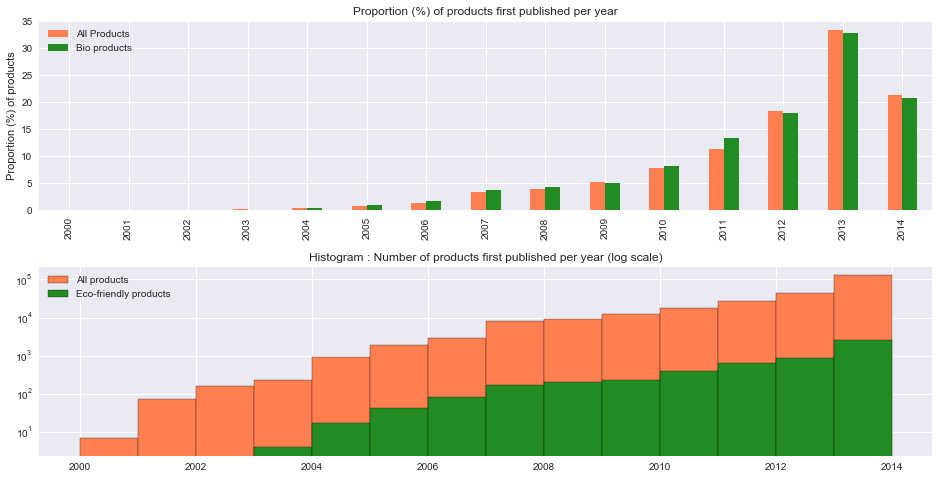

In [44]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,8)

ax1 = healthcare_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=axes[0])
ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")

ax2 = healthcareall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black',bins=14, ax=axes[1])
healthcarebio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black', log=True,bins=11,ax=ax2)

plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')

<br>

**PatioLawn Garden**

In [19]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
gardenbio_firstrev = patiolawn_garden_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardenbio_firstrev_pd = gardenbio_firstrev.toPandas()
gardenbio_firstrev_pd['Year'] = pd.to_datetime(gardenbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
gardenbio_firstrev_pd = gardenbio_firstrev_pd.drop('min(unixReviewTime)', axis=1)


# Compute and aggregate first review --> publication year of the product : All products
gardeneall_firstrev = patiolawn_garden_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
gardeneall_firstrev_pd = gardeneall_firstrev.toPandas()
gardeneall_firstrev_pd['Year'] = pd.to_datetime(gardeneall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
gardeneall_firstrev_pd = gardeneall_firstrev_pd.drop(['min(unixReviewTime)'], axis=1)

In [42]:
#Compute Histogram of ecofriendly products publication years
gardenbio_firstrev_index = np.sort(gardenbio_firstrev_pd['Year'].unique())
gardenbio_firstrev_histogram,_ = np.histogram(gardenbio_firstrev_pd['Year'], len(gardenbio_firstrev_index), density=True)

gardenbio_firstrev_serie = pd.Series(gardenbio_firstrev_histogram, index=gardenbio_firstrev_index)*100
gardenbio_firstrev_serie = gardenbio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
gardenall_firstrev_index = np.sort(gardeneall_firstrev_pd['Year'].unique())
gardenall_firstrev_histogram,_ = np.histogram(gardeneall_firstrev_pd['Year'], len(gardenall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
garden_firstrev_histogram = pd.DataFrame(gardenall_firstrev_histogram, index=gardenall_firstrev_index, columns=['All Products']) *100  
garden_firstrev_histogram['Ecofriendly products'] = gardenbio_firstrev_serie
garden_firstrev_histogram = garden_firstrev_histogram.fillna(0)

Text(0.5,1,'Histogram : Number of products first published per year (log scale)')

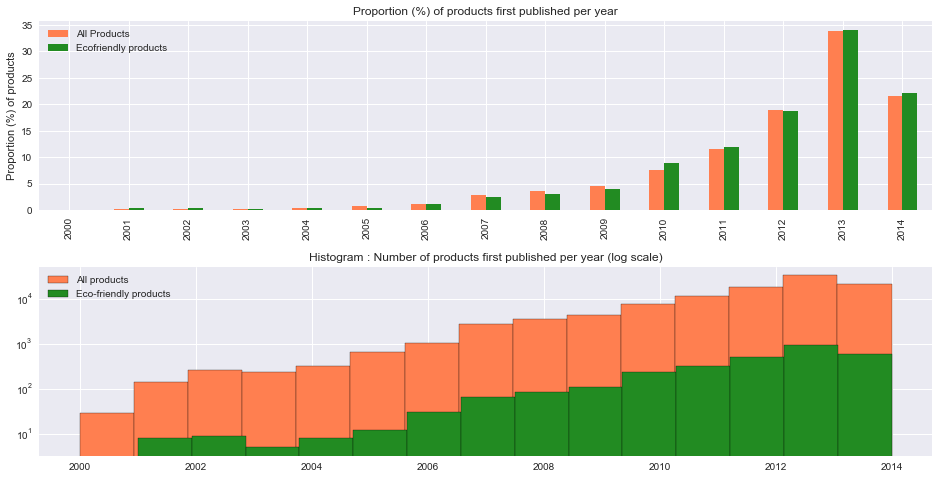

In [45]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,8)

ax1 = garden_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=axes[0])
ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")

ax2 = gardeneall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black', bins=15, ax=axes[1])
gardenbio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black', log=True,bins=14,ax=ax2)

plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')

<br>

**Books**

In [ ]:
booksbio_firstrev = books_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksbio_firstrev_pd = booksbio_firstrev.toPandas()
booksbio_firstrev_pd['Year'] = pd.to_datetime(booksbio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

booksall_firstrev = books_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
booksall_firstrev_pd = booksall_firstrev.toPandas()
booksall_firstrev_pd['Year'] = pd.to_datetime(booksall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [ ]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(16,4)

ax = booksall_firstrev_pd.hist("Year", log=True, color="coral", bins=18, ax=axes)
booksbio_firstrev_pd.hist("Year", color="green", log=True,bins=17,ax=ax)

plt.title('Number of products per year (log scale)')
axes.legend(['All products',"Eco-friendly products"])

plt.show()

**Home and Kitchen**

In [52]:
# Compute and aggregate first review --> publication year of the product : Ecofriendly products
homebio_firstrev = home_review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
homebio_firstrev_pd = homebio_firstrev.toPandas()
homebio_firstrev_pd['Year'] = pd.to_datetime(homebio_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

# Compute and aggregate first review --> publication year of the product : All products
homeall_firstrev = home_reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))
homeall_firstrev_pd = homeall_firstrev.toPandas()
homeall_firstrev_pd['Year'] = pd.to_datetime(homeall_firstrev_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

In [53]:
#Compute Histogram of ecofriendly products publication years
homebio_firstrev_index = np.sort(homebio_firstrev_pd['Year'].unique())
homebio_firstrev_histogram,_ = np.histogram(homebio_firstrev_pd['Year'], len(homebio_firstrev_index), density=True)

homebio_firstrev_serie = pd.Series(homebio_firstrev_histogram, index=homebio_firstrev_index)*100
homebio_firstrev_serie = homebio_firstrev_serie.sort_index()

#Compute Histogram of all products publication years
homeall_firstrev_index = np.sort(homeall_firstrev_pd['Year'].unique())
homeall_firstrev_histogram,_ = np.histogram(homeall_firstrev_pd['Year'], len(homeall_firstrev_index), density=True)

# Merge the 2 histograms in a dataframe
home_firstrev_histogram = pd.DataFrame(homeall_firstrev_histogram, index=homeall_firstrev_index, columns=['All Products']) *100  
home_firstrev_histogram['Ecofriendly products'] = homebio_firstrev_serie
home_firstrev_histogram = home_firstrev_histogram.fillna(0)

Text(0.5,1,'Histogram : Number of products first published per year (log scale)')

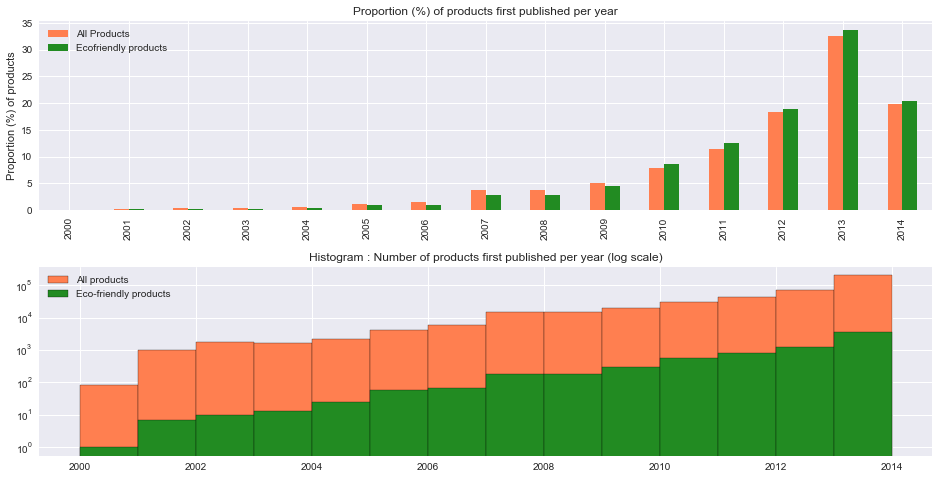

In [54]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(16,8)

ax1 = home_firstrev_histogram.plot(kind='bar',color=['coral','forestgreen'], ax=axes[0])
ax1.set_title("Proportion (%) of products first published per year")
ax1.set_ylabel("Proportion (%) of products")


ax2 = homeall_firstrev_pd.hist("Year", log=True, color="coral", edgecolor='black', bins=14, ax=axes[1])
homebio_firstrev_pd.hist("Year", color="forestgreen", edgecolor='black',log=True,bins=14,ax=ax2)

plt.legend(['All products',"Eco-friendly products"])
plt.title('Histogram : Number of products first published per year (log scale)')

<br>

#### **3) Distribution of the number of comments by product**

Now we are goin to interest in the reviews distribution over the eco-friendly items in order to find a relevant trend or behavior in those items.
For each product, we count by id the number of reviews received and the frequency of it. This is also an indicator of how much can people be interested in.

<br>

**Grocery Food**

In [29]:
grocerybio_nbrev_perproduct=  grocery_food_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [30]:
grocerybio_nbreviews_DF = spark.createDataFrame(grocerybio_nbrev_perproduct, ['productID','freq'])

In [31]:
grocerybio_nbreviews_Pandas = grocerybio_nbreviews_DF.toPandas()

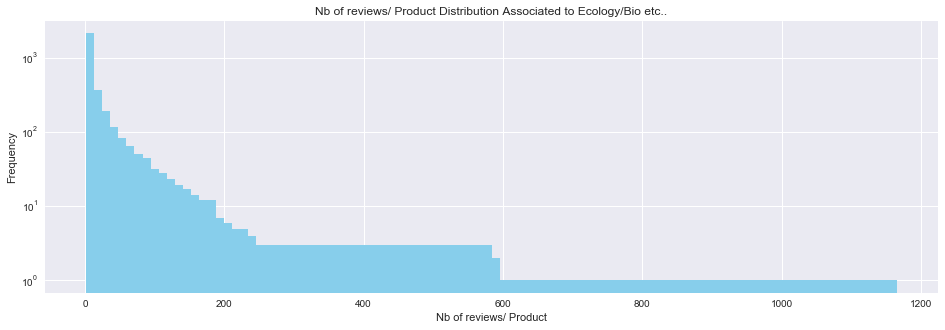

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
grocerybio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

**Healthcare**

In [33]:
healthcarebio_nbrev_perproduct=  healthcare_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [34]:
healthcarebio_nbreviews_DF = spark.createDataFrame(healthcarebio_nbrev_perproduct, ['productID','freq'])

In [35]:
healthcarebio_nbreviews_pd = healthcarebio_nbreviews_DF.toPandas()

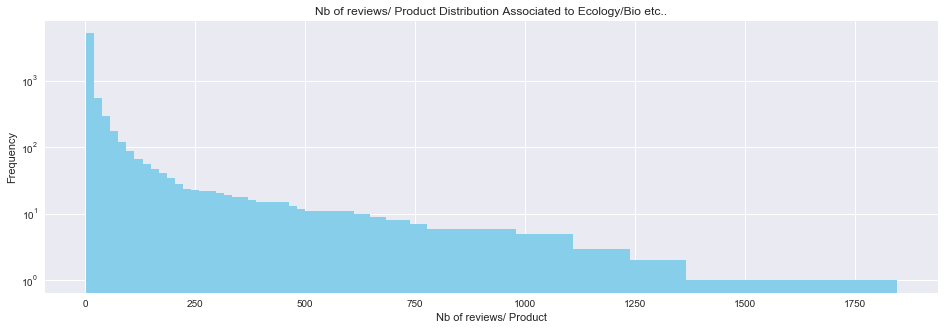

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
healthcarebio_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

**Patio Lawn Garden**

In [37]:
gardenbio_nbrev_perproduct=  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [38]:
gardenbio_nbreviews_DF = spark.createDataFrame(gardenbio_nbrev_perproduct, ['productID','freq'])

In [39]:
gardenbio_nbreviews_pd = gardenbio_nbreviews_DF.toPandas()

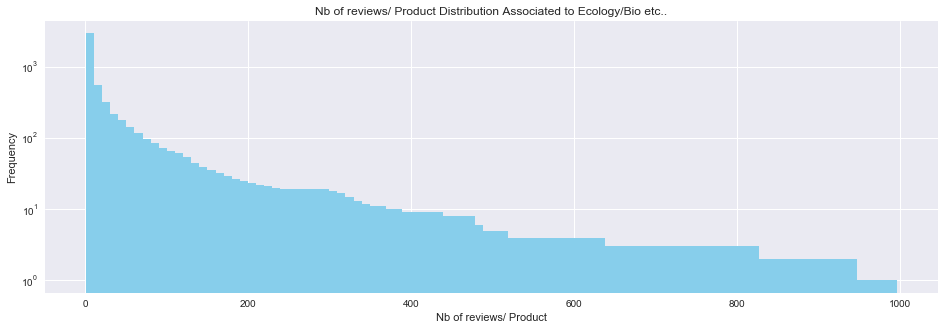

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
gardenbio_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

In [41]:
gardenall_nbrev_perproduct=  patiolawn_garden_reviews.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [42]:
gardenall_nbreviews_DF = spark.createDataFrame(gardenall_nbrev_perproduct, ['productID','freq'])

In [43]:
gardenall_nbreviews_pd = gardenall_nbreviews_DF.toPandas()

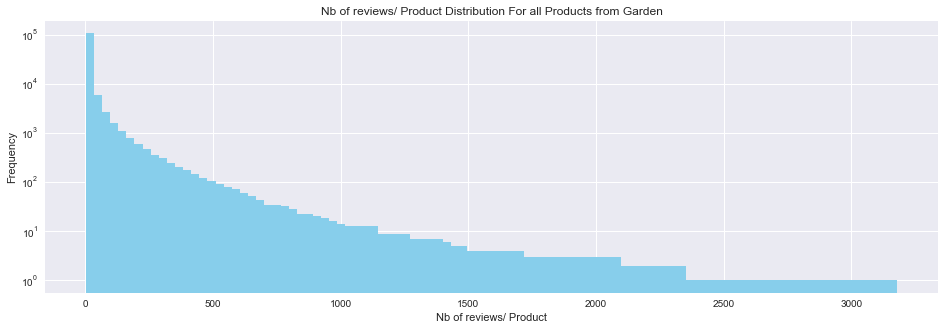

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
gardenall_nbreviews_pd.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution For all Products from Garden")
plt.show()

<br>

**Books**

In [ ]:
booksbio_nbrev_perproduct=  books_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [ ]:
booksbio_nbreviews_DF = spark.createDataFrame(booksbio_nbrev_perproduct, ['productID','freq'])

In [ ]:
booksbio_nbreviews_Pandas = booksbio_nbreviews_DF.toPandas()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
booksbio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

**Home and Kitchen**

In [45]:
homebio_nbrev_perproduct = home_review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [46]:
homebio_nbreviews_DF = spark.createDataFrame(homebio_nbrev_perproduct, ['productID','freq'])

In [47]:
homebio_nbreviews_Pandas = homebio_nbreviews_DF.toPandas()

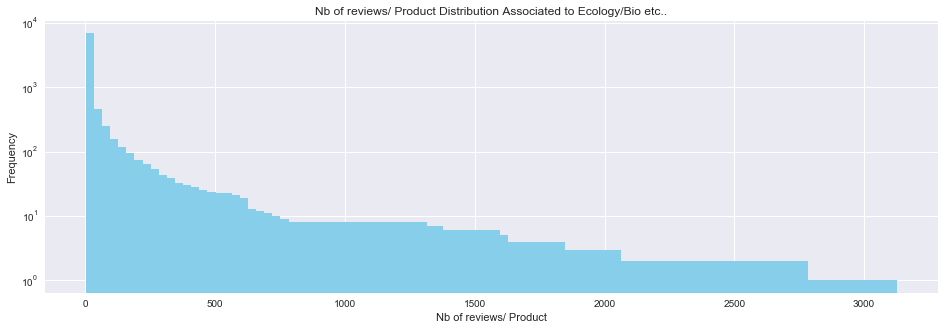

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True); fig.set_size_inches(16,5)
homebio_nbreviews_Pandas.hist(log=True, bins = 100, color="skyblue", cumulative=-1, ax=axes)
axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")
plt.show()

<br>

####  **4) Price average per year**


Eco-friendly products can be more expensive due to some high cost production (such as bio product for example). So as we did before, we are going to analyse what we can extract from that. 

As we did in the second section, we compute for each item its released year in a new dataframe. Then when the price of the item if definine, we add it to the dataframe for each item’s id.
And finally we count the mean of the prices for every year. Sometimes it can happend that some years do not have prices (either the price was set to null or there were no items). So we ad dit by a 0 price. 
As we said, eco-product is not a very old concept in our society and might not be present at the beginning of the sales or described as eco-product. 

What we expect : by the time goes, the importance and price of product over the time.


**1) Grocery Food**

In [49]:
grocery_products_bio_df = spark.createDataFrame(grocery_filter_products_bio)

grocery_year_join = grocery_products_bio_df.join(grocerybio_firstrev, ['asin'])
grocery_year_join_pd = grocery_year_join.toPandas()

grocery_year_join_pd['Year'] = pd.to_datetime(grocery_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
grocery_year_join_pd = grocery_year_join_pd[np.isfinite(grocery_year_join_pd['price'])]

grocery_year_join_pd = grocery_year_join_pd[['price', 'Year']]

grocery_year_join_pd_mean = grocery_year_join_pd.groupby(['Year']).mean()
grocery_year_join_nb_products,_ = np.histogram(grocery_year_join_pd['Year'], bins=len(grocery_year_join_pd_mean))
grocery_year_join_pd_mean.columns = ['price : Bio products']

grocery_year_join_pd_error = grocery_year_join_pd.groupby(['Year']).std()
for i in range(len(grocery_year_join_pd_mean)):
    grocery_year_join_pd_error.iloc[i] = grocery_year_join_pd_error.iloc[i]/grocery_year_join_nb_products[i]


In [50]:
grocery_year_join_pd_mean.loc[2000] = 0
grocery_year_join_pd_mean.loc[2002] = 0
grocery_year_join_pd_mean.loc[2003] = 0
grocery_year_join_pd_mean = grocery_year_join_pd_mean.sort_index()

In [51]:
# Mean of price per year of all products from Patio lawn and Garden
grocery_all_year_join = grocery_food_datacleaned.join(groceryall_firstrev, ['asin'])
grocery_all_year_join_pd = grocery_all_year_join.toPandas()

grocery_all_year_join_pd['Year'] = pd.to_datetime(grocery_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

grocery_all_year_join_pd = grocery_all_year_join_pd[np.isfinite(grocery_all_year_join_pd['price'])]
grocery_all_year_join_pd = grocery_all_year_join_pd[['price', 'Year']]

grocery_all_year_join_pd = grocery_all_year_join_pd.groupby(['Year']).mean()

grocery_all_year_join_pd.columns =['price : all products']

Text(0.5,1,'Grocery : Mean price of products per year $')

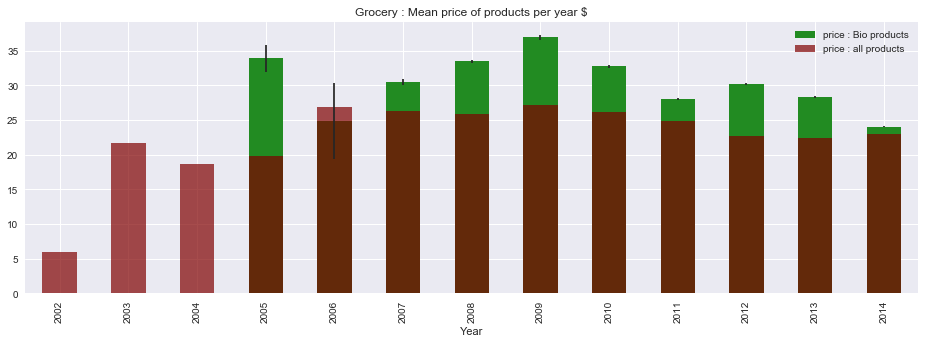

In [52]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = grocery_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=grocery_year_join_pd_error['price'])
grocery_all_year_join_pd.plot(kind='bar', alpha=0.7, color='maroon', ax =ax)
plt.title('Grocery : Mean price of products per year $')

**2) Healthcare**

In [53]:
healthcare_products_bio_df = spark.createDataFrame(healthcare_filter_products_bio)

healthcarebio_year_join = healthcare_products_bio_df.join(healthcarebio_firstrev, ['asin'])
healthcarebio_year_join_pd = healthcarebio_year_join.toPandas()

healthcarebio_year_join_pd['Year'] = pd.to_datetime(healthcarebio_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
healthcarebio_year_join_pd = healthcarebio_year_join_pd[np.isfinite(healthcarebio_year_join_pd['price'])]

healthcarebio_year_join_pd = healthcarebio_year_join_pd[['price', 'Year']]

healthcarebio_year_join_pd_mean = healthcarebio_year_join_pd.groupby(['Year']).mean()
healthcarebio_year_join_nb_products,_ = np.histogram(healthcarebio_year_join_pd['Year'], bins=len(healthcarebio_year_join_pd_mean))

healthcarebio_year_join_pd_mean.columns = ['price : Bio products']


healthcarebio_year_join_pd_error = healthcarebio_year_join_pd.groupby(['Year']).std()
for i in range(len(healthcarebio_year_join_pd_mean)):
    healthcarebio_year_join_pd_error.iloc[i] = healthcarebio_year_join_pd_error.iloc[i]/healthcarebio_year_join_nb_products[i]


In [54]:
healthcarebio_year_join_pd_mean.loc[1998] = 0
healthcarebio_year_join_pd_mean.loc[1999] = 0
healthcarebio_year_join_pd_mean.loc[2000] = 0
healthcarebio_year_join_pd_mean.loc[2001] = 0
healthcarebio_year_join_pd_mean.loc[2002] = 0
healthcarebio_year_join_pd_mean = healthcarebio_year_join_pd_mean.sort_index()

In [55]:
# Mean of price per year of all products from Patio lawn and Garden
healthcare_all_year_join = healthcare_datacleaned.join(healthcareall_firstrev, ['asin'])
healthcare_all_year_join_pd = healthcare_all_year_join.toPandas()

healthcare_all_year_join_pd['Year'] = pd.to_datetime(healthcare_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

healthcare_all_year_join_pd = healthcare_all_year_join_pd[np.isfinite(healthcare_all_year_join_pd['price'])]
healthcare_all_year_join_pd = healthcare_all_year_join_pd[['price', 'Year']]

healthcare_all_year_join_pd = healthcare_all_year_join_pd.groupby(['Year']).mean()

healthcare_all_year_join_pd.columns =['price : all products']

Text(0.5,1,'Healthcare : Mean price of products per year $')

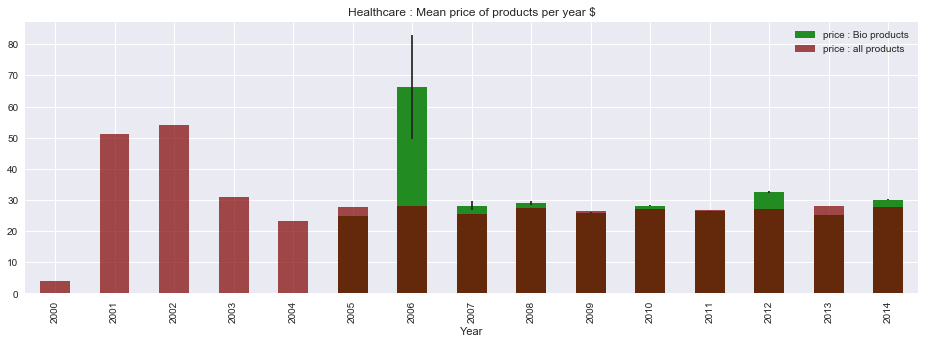

In [56]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = healthcarebio_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=healthcarebio_year_join_pd_error['price'])
healthcare_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='maroon')
plt.title('Healthcare : Mean price of products per year $')

**3) Patio Lawn Garden**

In [57]:
DF_filter_products_bio = spark.createDataFrame(patiolawn_garden_filter_products_bio)

garden_year_join = DF_filter_products_bio.join(gardenbio_firstrev, ['asin'])
garden_year_join_pd = garden_year_join.toPandas()

garden_year_join_pd['Year'] = pd.to_datetime(garden_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
garden_year_join_pd = garden_year_join_pd[np.isfinite(garden_year_join_pd['price'])]

garden_year_join_pd = garden_year_join_pd[['price', 'Year']]

garden_year_join_pd_mean = garden_year_join_pd.groupby(['Year']).mean()
garden_year_join_pd_nb_products,_ = np.histogram(garden_year_join_pd['Year'], bins=len(garden_year_join_pd_mean))

garden_year_join_pd_mean.columns = ['price : Bio products']

garden_year_join_pd_error = garden_year_join_pd.groupby(['Year']).std()
for i in range(len(garden_year_join_pd_error)):
    garden_year_join_pd_error.iloc[i] = garden_year_join_pd_error.iloc[i]/garden_year_join_pd_nb_products[i]


In [58]:
# Mean of price per year of all products from Patio lawn and Garden
garden_all_year_join = patiolawn_garden_datacleaned.join(gardeneall_firstrev, ['asin'])
garden_all_year_join_pd = garden_all_year_join.toPandas()

garden_all_year_join_pd['Year'] = pd.to_datetime(garden_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

garden_all_year_join_pd = garden_all_year_join_pd[np.isfinite(garden_all_year_join_pd['price'])]
garden_all_year_join_pd = garden_all_year_join_pd[['price', 'Year']]

garden_all_year_join_pd = garden_all_year_join_pd.groupby(['Year']).mean()

garden_all_year_join_pd.columns =['price : all products']

In [59]:
garden_year_join_pd_mean.loc[1998] = 0
garden_year_join_pd_mean.loc[1999] = 0
garden_year_join_pd_mean = garden_year_join_pd_mean.sort_index()

Text(0.5,1,'Patio Lawn - Garden : Mean price of products per year $')

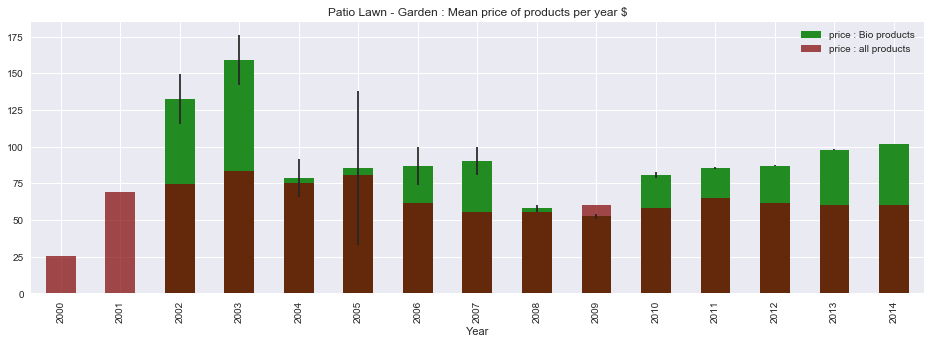

In [60]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = garden_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=garden_year_join_pd_error['price'])
garden_all_year_join_pd.plot(kind='bar', ax = ax, alpha=0.7, color='maroon')
plt.title('Patio Lawn - Garden : Mean price of products per year $')

**4) Home and Kitchen**

In [61]:
home_filter_products_bio = spark.createDataFrame(home_filter_eco)

home_year_join = home_filter_products_bio.join(homeall_firstrev, ['asin'])
home_year_join_pd = home_year_join.toPandas()

home_year_join_pd['Year'] = pd.to_datetime(home_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)
home_year_join_pd = home_year_join_pd[np.isfinite(home_year_join_pd['price'])]

home_year_join_pd = home_year_join_pd[['price', 'Year']]

home_year_join_pd_mean = home_year_join_pd.groupby(['Year']).mean()
home_year_join_pd_nb_products,_ = np.histogram(home_year_join_pd['Year'], bins=len(home_year_join_pd_mean))

home_year_join_pd_mean.columns = ['price : Bio products']

home_year_join_pd_error = home_year_join_pd.groupby(['Year']).std()
for i in range(len(home_year_join_pd_error)):
    home_year_join_pd_error.iloc[i] = home_year_join_pd_error.iloc[i]/home_year_join_pd_nb_products[i]


In [62]:
# Mean of price per year of all products from Patio lawn and Garden
home_all_year_join = home_datacleaned.join(homeall_firstrev, ['asin'])
home_all_year_join_pd = home_all_year_join.toPandas()

home_all_year_join_pd['Year'] = pd.to_datetime(home_all_year_join_pd['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

home_all_year_join_pd = home_all_year_join_pd[np.isfinite(home_all_year_join_pd['price'])]
home_all_year_join_pd = home_all_year_join_pd[['price', 'Year']]

home_all_year_join_pd = home_all_year_join_pd.groupby(['Year']).mean()

home_all_year_join_pd.columns =['price : all products']

In [63]:
home_year_join_pd_mean.loc[2000] = 0
home_year_join_pd_mean = home_year_join_pd_mean.sort_index()

Text(0.5,1,'Home and Kitchen : Mean price of products per year $')

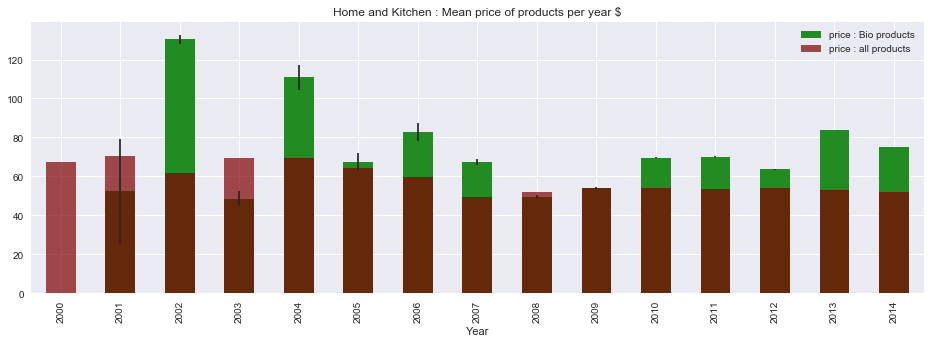

In [64]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

ax = home_year_join_pd_mean.plot(kind='bar', color='forestgreen', ax = axes, yerr=home_year_join_pd_error['price'])
home_all_year_join_pd.plot(kind='bar' , ax = ax,alpha=0.7, color='maroon')
plt.title('Home and Kitchen : Mean price of products per year $')

We can see in these graph above that the ecofriendy products are in average more expensive than the global products for each category. However we can not observe a growing trend in the price for these products. 

This field came in the market a bit late. We can see that the first years the ecofriendly products were really expensive.

__Global Price Information per Category__

In [65]:
def price_difference_percentage(ecofriendly_series, all_series):
    difference = ecofriendly_series.divide(all_series)*100
    difference = difference.iloc[difference.nonzero()]
    difference = difference.mean()-100
    
    return difference

In [66]:
def price_difference_dollars(ecofriendly_series, all_series):
    difference = ecofriendly_series.sub(all_series)
    difference = difference.iloc[ecofriendly_series.nonzero()]
    difference = difference.mean()
    
    return difference

In [67]:
home_difference_perc = price_difference_percentage(home_year_join_pd_mean['price : Bio products'], \
                                                   home_all_year_join_pd['price : all products'])

grocery_difference_perc = price_difference_percentage(grocery_year_join_pd_mean['price : Bio products'], \
                                                      grocery_all_year_join_pd['price : all products'])

healthcare_difference_perc = price_difference_percentage(healthcarebio_year_join_pd_mean['price : Bio products'], \
                                                         healthcare_all_year_join_pd['price : all products'])

garden_difference_perc = price_difference_percentage(garden_year_join_pd_mean['price : Bio products'], \
                                                     garden_all_year_join_pd['price : all products'])


difference_perc_df = pd.DataFrame([home_difference_perc,grocery_difference_perc,healthcare_difference_perc,garden_difference_perc], \
                                  index=['home','grocery','healthcare','garden'], columns=["Difference Percentage %"])


In [68]:
home_difference_dollars = price_difference_dollars(home_year_join_pd_mean['price : Bio products'], \
                                                   home_all_year_join_pd['price : all products'])

grocery_difference_dollars = price_difference_dollars(grocery_year_join_pd_mean['price : Bio products'], \
                                                      grocery_all_year_join_pd['price : all products'])

healthcare_difference_dollars = price_difference_dollars(healthcarebio_year_join_pd_mean['price : Bio products'], \
                                                         healthcare_all_year_join_pd['price : all products'])

garden_difference_dollars = price_difference_dollars(garden_year_join_pd_mean['price : Bio products'], \
                                                     garden_all_year_join_pd['price : all products'])

difference_dollars_df = pd.DataFrame([home_difference_dollars,grocery_difference_dollars,healthcare_difference_dollars,garden_difference_dollars], \
                                     index=['home','grocery','healthcare','garden'], columns=["Diffrence Dollars $"])

In [69]:
homebio_mean_dollars = home_year_join_pd_mean['price : Bio products'].iloc[1:-1].mean()
homeall_mean_dollars = home_all_year_join_pd['price : all products'].iloc[1:-1].mean()

grocerybio_mean_dollars = grocery_year_join_pd_mean['price : Bio products'].iloc[3:-1].mean()
groceryall_mean_dollars = grocery_all_year_join_pd['price : all products'].iloc[3:-1].mean()

healthcarebio_mean_dollars = healthcarebio_year_join_pd_mean['price : Bio products'].iloc[5:-1].mean()
healthcareall_mean_dollars = healthcare_all_year_join_pd['price : all products'].iloc[5:-1].mean()

gardenbio_mean_dollars = garden_year_join_pd_mean['price : Bio products'].iloc[2:-1].mean()
gardenall_mean_dollars = garden_all_year_join_pd['price : all products'].iloc[2:-1].mean()

mean_price_df = pd.DataFrame([[homebio_mean_dollars,homeall_mean_dollars],\
                             [grocerybio_mean_dollars,groceryall_mean_dollars],\
                             [healthcarebio_mean_dollars,healthcareall_mean_dollars],\
                             [gardenbio_mean_dollars,gardenall_mean_dollars]],\
                             index=['home','grocery','healthcare','garden'], columns=["Ecofriendly Mean_Price","All Mean_Price"])


Text(0.5,1,'Average Price ($) per Category')

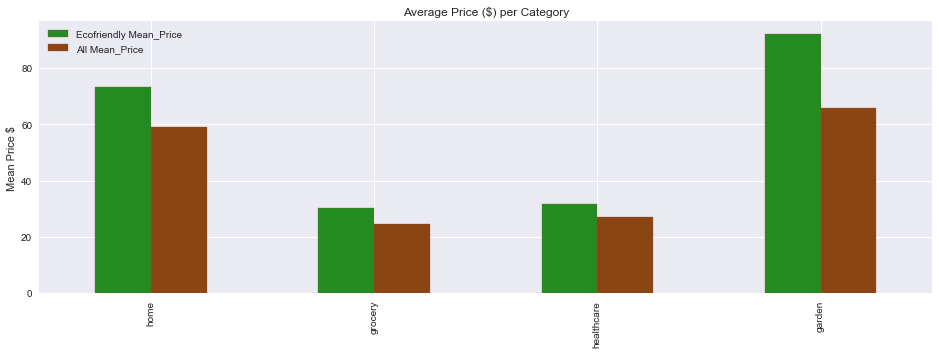

In [70]:
fig, axes = plt.subplots(1,1); fig.set_size_inches(16,5)

mycolor = ['forestgreen','saddlebrown']
mean_price_df.plot(kind='bar', ax=axes, color=mycolor,edgecolor='sienna')
plt.ylabel("Mean Price $")
plt.title("Average Price ($) per Category")

Text(0.5,1,'Mean Price Difference ($) between Ecofriendly products VS All products')

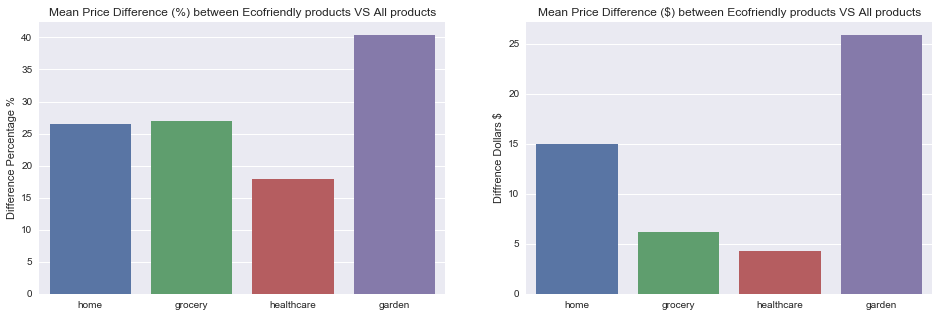

In [71]:
fig, axes = plt.subplots(1,2); fig.set_size_inches(16,5)


ax1 = sns.barplot(x=difference_perc_df.index,y=difference_perc_df['Difference Percentage %'], ax=axes[0])
ax1.set_title("Mean Price Difference (%) between Ecofriendly products VS All products")
ax2 = sns.barplot(x=difference_dollars_df.index,y=difference_dollars_df['Diffrence Dollars $'], ax=axes[1])
ax2.set_title("Mean Price Difference ($) between Ecofriendly products VS All products")

### Overall rating per Category

**1) Grocery Food**

In [72]:
grocerybio_overall =  grocery_food_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [73]:
grocerybio_overall_DF = spark.createDataFrame(grocerybio_overall)

grocerybio_overall_pd = grocerybio_overall_DF.toPandas()
grocerybio_overall_pd.columns= ['overall','occurences']
grocerybio_overall_pd = grocerybio_overall_pd.set_index('overall')

grocerybio_sum_ratings = grocerybio_overall_pd['occurences'].sum()
grocerybio_percentage = grocerybio_overall_pd['occurences'].divide(grocerybio_sum_ratings)

In [74]:
groceryall_overall =  grocery_food_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [75]:
groceryall_overall_df = spark.createDataFrame(groceryall_overall)

groceryall_overall_pd = groceryall_overall_df.toPandas()
groceryall_overall_pd.columns= ['overall','occurences']
groceryall_overall_pd = groceryall_overall_pd.set_index('overall')

groceryall_sum_ratings = groceryall_overall_pd['occurences'].sum()
groceryall_percentage = groceryall_overall_pd['occurences'].divide(groceryall_sum_ratings)

In [76]:
grocery_rating_proportion = pd.DataFrame()
grocery_rating_proportion['All Products Proportion'] = groceryall_percentage*100
grocery_rating_proportion['Ecofriendly Products Proportion'] = grocerybio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

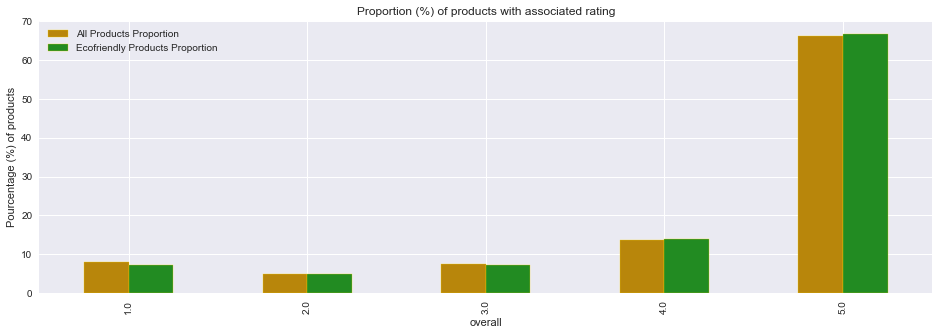

In [77]:
fig, axes = plt.subplots(1,1); 
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

grocery_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

**2) Healthcare**

In [78]:
healthcarebio_overall =  healthcare_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [79]:
healthcarebio_overall_DF = spark.createDataFrame(healthcarebio_overall)

healthcarebio_overall_pd = healthcarebio_overall_DF.toPandas()
healthcarebio_overall_pd.columns= ['overall','occurences']
healthcarebio_overall_pd = healthcarebio_overall_pd.set_index('overall')

healthcarebio_sum_ratings = healthcarebio_overall_pd['occurences'].sum()
healthcarebio_percentage = healthcarebio_overall_pd['occurences'].divide(healthcarebio_sum_ratings)

In [80]:
healthcareall_overall =  healthcare_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [81]:
healthcareall_overall_df = spark.createDataFrame(healthcareall_overall)

healthcareall_overall_pd = healthcareall_overall_df.toPandas()
healthcareall_overall_pd.columns= ['overall','occurences']
healthcareall_overall_pd = healthcareall_overall_pd.set_index('overall')

healthcareall_sum_ratings = healthcareall_overall_pd['occurences'].sum()
healthcareall_percentage = healthcareall_overall_pd['occurences'].divide(healthcareall_sum_ratings)

In [82]:
healthcare_rating_proportion = pd.DataFrame()
healthcare_rating_proportion['All Products Proportion'] = healthcareall_percentage*100
healthcare_rating_proportion['Ecofriendly Products Proportion'] = healthcarebio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

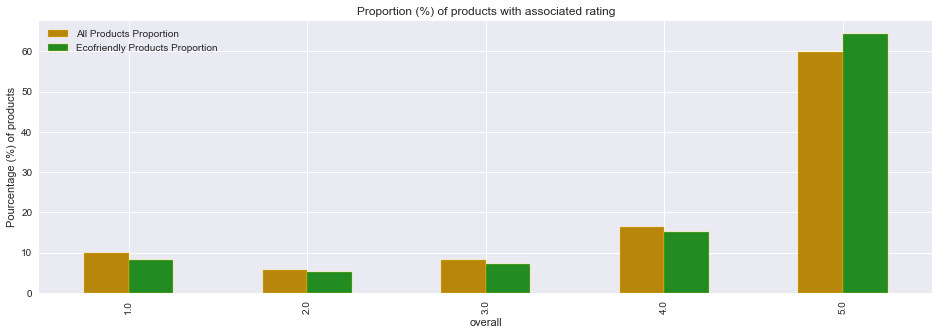

In [83]:
fig, axes = plt.subplots(1,1); 
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

healthcare_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

**3) Patio Garden**

In [84]:
gardenbio_overall =  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [85]:
gardenbio_overall_DF = spark.createDataFrame(gardenbio_overall)

gardenbio_overall_pd = gardenbio_overall_DF.toPandas()
gardenbio_overall_pd.columns= ['overall','occurences']
gardenbio_overall_pd = gardenbio_overall_pd.set_index('overall')

gardenbio_sum_ratings = gardenbio_overall_pd['occurences'].sum()
gardenbio_percentage = gardenbio_overall_pd['occurences'].divide(gardenbio_sum_ratings)

In [86]:
gardenall_overall =  patiolawn_garden_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [87]:
gardenall_overall_df = spark.createDataFrame(gardenall_overall)

gardenall_overall_pd = gardenall_overall_df.toPandas()
gardenall_overall_pd.columns= ['overall','occurences']
gardenall_overall_pd = gardenall_overall_pd.set_index('overall')

gardenall_sum_ratings = gardenall_overall_pd['occurences'].sum()
gardenall_percentage = gardenall_overall_pd['occurences'].divide(gardenall_sum_ratings)

In [88]:
garden_rating_proportion = pd.DataFrame()
garden_rating_proportion['All Products Proportion'] = gardenall_percentage*100
garden_rating_proportion['Ecofriendly Products Proportion'] = gardenbio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

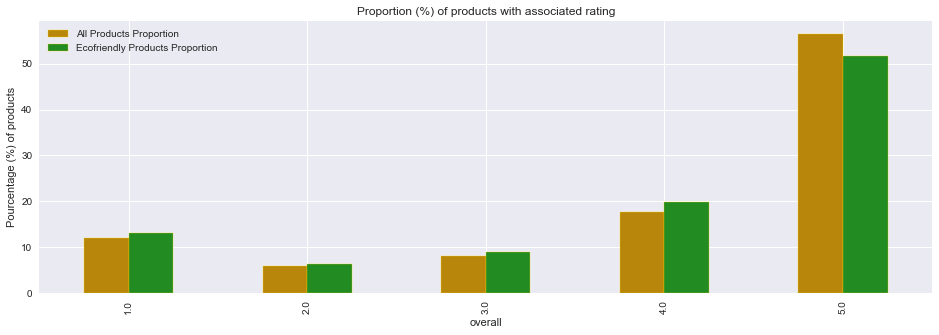

In [89]:
fig, axes = plt.subplots(1,1); 
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

garden_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

**4) Home Kitchen**

In [90]:
homebio_overall =  home_review_product_join.rdd.map(lambda r: [r[8],1]) \
            .reduceByKey(lambda a,b: a+b)

In [91]:
homebio_overall_DF = spark.createDataFrame(homebio_overall)

homebio_overall_pd = homebio_overall_DF.toPandas()
homebio_overall_pd.columns= ['overall','occurences']
homebio_overall_pd = homebio_overall_pd.set_index('overall')

homebio_sum_ratings = homebio_overall_pd['occurences'].sum()
homebio_percentage = homebio_overall_pd['occurences'].divide(homebio_sum_ratings)

In [92]:
homeall_overall =  home_reviews.rdd.map(lambda r: [r[2],1]) \
            .reduceByKey(lambda a,b: a+b)

In [93]:
homeall_overall_df = spark.createDataFrame(homeall_overall)

homeall_overall_pd = homeall_overall_df.toPandas()
homeall_overall_pd.columns= ['overall','occurences']
homeall_overall_pd = homeall_overall_pd.set_index('overall')

homeall_sum_ratings = homeall_overall_pd['occurences'].sum()
homeall_percentage = homeall_overall_pd['occurences'].divide(homeall_sum_ratings)

In [94]:
home_rating_proportion = pd.DataFrame()
home_rating_proportion['All Products Proportion'] = homeall_percentage*100
home_rating_proportion['Ecofriendly Products Proportion'] = homebio_percentage*100

Text(0,0.5,'Pourcentage (%) of products')

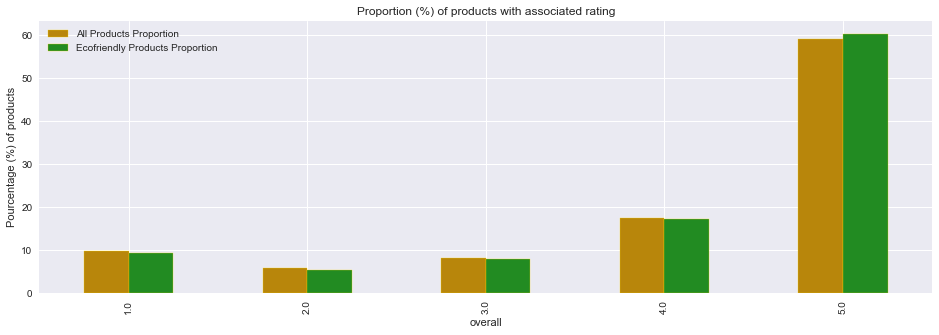

In [95]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(16,5)
mycolor = ['darkgoldenrod','forestgreen']

home_rating_proportion.plot(kind='bar', color=mycolor, edgecolor='gold', ax=axes)
plt.title("Proportion (%) of products with associated rating")
plt.ylabel("Pourcentage (%) of products")

__Global Overall Rating Comparison__

In [96]:
grocerybio_mean_rating = grocery_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
groceryall_mean_rating = grocery_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100

healthcarebio_mean_rating= healthcare_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
healthcareall_mean_rating = healthcare_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100

gardenbio_mean_rating = garden_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
gardenall_mean_rating = garden_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100

homebio_mean_rating = home_rating_proportion["Ecofriendly Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100
homeall_mean_rating = home_rating_proportion["All Products Proportion"].multiply(grocery_rating_proportion.index).sum()/100


In [97]:
mean_rating = pd.DataFrame(index=['grocery','healthcare','garden','home'])
mean_rating['Mean Bio Rating'] = [grocerybio_mean_rating,healthcarebio_mean_rating,gardenbio_mean_rating,homebio_mean_rating]
mean_rating['Mean All Rating'] = [groceryall_mean_rating,healthcareall_mean_rating,gardenall_mean_rating,homeall_mean_rating]

Text(0,0.5,'Overall rating')

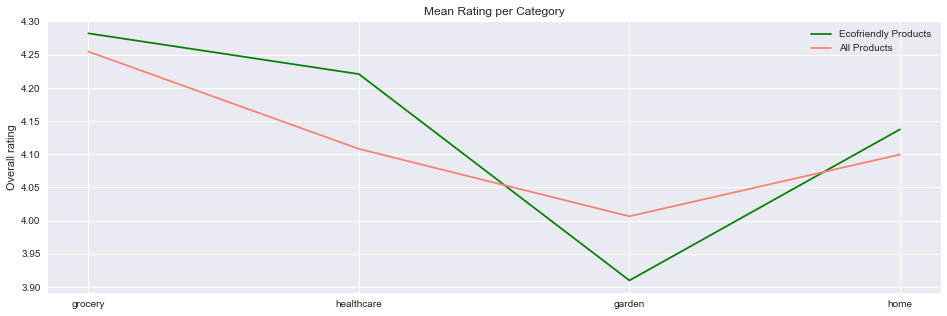

In [98]:
fig, axes = plt.subplots()
fig.set_size_inches(16,5)

axes.plot(mean_rating.index,mean_rating['Mean Bio Rating'], label="Ecofriendly Products", color='green')
axes.plot(mean_rating.index,mean_rating['Mean All Rating'], label="All Products", color='salmon')

plt.title("Mean Rating per Category")
plt.legend(['Ecofriendly Products', 'All Products'])
plt.ylabel("Overall rating")

### Correlation SalesRank and Rating Analysis
We now want to analyze the correlations with the salerank.
Indeed, is the salerank position related to the number of reviews or the overall rating of the products ?
We will even add the publication year of each product.

In [410]:
# Average rating for each products
# First, add every overall rating for each product (we will divide by the number of reviews after)
gardenall_product_rating =  patiolawn_garden_reviews.rdd.map(lambda r: [r[0],r[2]]) \
            .reduceByKey(lambda a,b: a+b)

gardenall_product_rating_df = spark.createDataFrame(gardenall_product_rating)

gardenall_product_rating_pd = gardenall_product_rating_df.toPandas()
gardenall_product_rating_pd.columns= ['productID','rating']

# Join average rating per product with number of reviews per product
# the index is productID
gardenall_info_products = gardenall_nbreviews_pd.set_index('productID').join(gardenall_product_rating_pd.set_index('productID'))


gardenall_info_products.columns = ['nb_reviews','rating']
# Divide the rating by the number of overall ratings per product
gardenall_info_products['rating'] = gardenall_info_products['rating'].divide(gardenall_info_products['nb_reviews'])


In [411]:
# Extract the salesRank per product
gardenall_salesrank = patiolawn_garden_datacleaned.rdd.flatMap(lambda r: [(r[0], r[5])])

schema = StructType([
    StructField("productID", StringType(), True),
    StructField("salesRank", IntegerType(), True)
])

gardenall_salesrank_df = spark.createDataFrame(gardenall_salesrank, schema=schema)
gardenall_salesrank_pd = gardenall_salesrank_df.toPandas()

# Join the previous dataframe (rating + nb_reviews) with salesRank
gardenall_info_products = gardenall_info_products.join(gardenall_salesrank_pd.set_index('productID'))
gardenall_info_products = gardenall_info_products.dropna()

# We will now add the Publication Year per product
gardeneall_firstrev_pd.columns = ['productID','Year']
gardenall_info_products = gardenall_info_products.join(gardeneall_firstrev_pd.set_index('productID'))

In [412]:
gardenall_info_products.sort_values('nb_reviews', ascending=False).head()

,nb_reviews,rating,salesRank,Year
productID,,,,
B000HCLLMM,3180,4.545283,1081.0,2007
B000071NUS,2348,4.266610,41.0,2003
B00004R9VV,2091,4.130560,111.0,2001
B00004SD7B,1707,4.793790,3668.0,2002
B000WEOQV8,1466,4.854707,9.0,2008


We will now try to observe the correlations between the columns. 

In [413]:
gardenall_filtered_info_products = gardenall_info_products[gardenall_info_products['nb_reviews']>100]

In [414]:
gardenall_filtered_info_products.corr()

,nb_reviews,rating,salesRank,Year
nb_reviews,1.000000,0.033764,-0.108203,-0.125247
rating,0.033764,1.000000,-0.090120,0.034341
salesRank,-0.108203,-0.090120,1.000000,-0.224840
Year,-0.125247,0.034341,-0.224840,1.000000


The correlation between the column do not give any valuable information. Indeed it seems there is no correlation between the columns. 
We will explore a bit further by grouping the different products in clusters following the 'Year' and the 'nb_reviews'. Then in these clusters which will have equivalent popularity (and associated year) we will check if the rating is correlated with the salesrank. 

In [415]:
#X = filtered['nb_reviews'].values
X = gardenall_filtered_info_products[['nb_reviews','Year']].values
numb_clusters = 80
kmeans = KMeans(n_clusters=numb_clusters, random_state=0).fit(X)

correlation_list = []
for i in range(numb_clusters):
    myind = kmeans.labels_ == i
    clustered_info_product = filtered.iloc[myind]
    if(len(clustered_info_product)>1):
        current_correlation = clustered_info_product['rating'].corr(clustered_info_product['salesRank'])
        correlation_list.append(current_correlation)

In [416]:
# Compute the average correlation between rating and salesrank
print("Average correlation (in clusters) between Rating and Salesrank : "+str(np.sum(correlation_list)/len(correlation_list)))

Average correlation (in clusters) between Rating and Salesrank : -0.04410063744041425


It seems that there is no correlation between the rating and the salesrank.
We can observe a cluster to understand why.

In [417]:
# This will show the last cluster computed
print("Correlation between Rating & salesRank for last cluster : "+str(current_correlation))
clustered_info_product

Correlation between Rating & salesRank for last cluster : 0.477247346073349


,nb_reviews,rating,salesRank,Year
productID,,,,
B002DM1Z5C,471,3.934183,588.0,2010
B00005AKZE,473,4.357294,2064.0,2002
B0000DINGG,477,3.784067,224.0,2007
B000NZZG3S,475,4.526316,564.0,2007
B0001WV010,477,4.584906,2728.0,2006
B002ZVOLY8,479,3.757829,1691.0,2010


The pearson correlation coefficient goes from -1 to 1. We could expect the correlation to be -1, if we think that if the rating is really high then the salesRank is really low (top position).

We can observe that the clustering is here well performed where the values in nb_reviews and year are equivalent.
Then, observing the rating feature, we can say that there is no correlation by hand.
Indeed taking the product 'B0000DINGG' with a rating of 3.78 which is low, has the best salesRank position. Whereas the product 'B0001WV010' with a rating of 4.584 which is the best of this cluster, possess the worst salesRank. 

After trying with different clusters numbers, different categories and using products eco-friendly or not, the behavior was remaining the same, there is __no correlation__. That is why we only showed the analysis for one case, avoiding the repetition leading to the same conclusion.

### Top Ecofriendly Products Analysis
> Patio Lawn Garden case analysis

__Extraction of top product__

In [449]:
# Average rating for each products
# First, add every overall rating for each product (we will divide by the number of reviews after)
gardenbio_product_rating =  patiolawn_garden_review_product_join.rdd.map(lambda r: [r[0],r[8]]) \
            .reduceByKey(lambda a,b: a+b)

gardenbio_product_rating_df = spark.createDataFrame(gardenbio_product_rating)

gardenbio_product_rating_pd = gardenbio_product_rating_df.toPandas()
gardenbio_product_rating_pd.columns= ['productID','rating']

# Join average rating per product with number of reviews per product
# the index is productID
gardenbio_info_products = gardenbio_nbreviews_pd.set_index('productID').join(gardenbio_product_rating_pd.set_index('productID'))


gardenbio_info_products.columns = ['nb_reviews','rating']
# Divide the rating by the number of overall ratings per product
gardenbio_info_products['rating'] = gardenbio_info_products['rating'].divide(gardenbio_info_products['nb_reviews'])


In [450]:
# Extract the salesRank per product
gardenbio_salesrank = patiolawn_garden_filter_products_bio.flatMap(lambda r: [(r[0], r[5])])

schema = StructType([
    StructField("productID", StringType(), True),
    StructField("salesRank", IntegerType(), True)
])

gardenbio_salesrank_df = spark.createDataFrame(gardenbio_salesrank, schema=schema)
gardenbio_salesrank_pd = gardenbio_salesrank_df.toPandas()

# Join the previous dataframe (rating + nb_reviews) with salesRank
gardenbio_info_products = gardenbio_info_products.join(gardenbio_salesrank_pd.set_index('productID'))
gardenbio_info_products = gardenbio_info_products.dropna()

# We will now add the Publication Year per product
gardenbio_firstrev_pd.columns = ['productID','Year']
gardenbio_info_products = gardenbio_info_products.join(gardenbio_firstrev_pd.set_index('productID'))

In [455]:
gardenbio_info_products.sort_values('salesRank').head()

,nb_reviews,rating,salesRank,Year
productID,,,,
B001AN7RGG,346,4.664740,21.0,2009
B0006OIZO8,166,4.409639,61.0,2009
B0030GEXUO,821,3.856273,96.0,2010
B000FOKXBW,50,4.080000,285.0,2010
B000NZZG3S,475,4.526316,564.0,2007


We observe that the best ecofriendly product for the category 'Patio Lawn Garden' is the 'B001AN7RGG' with a salesRank of 21 and nb_reviews = 346 and the publication year = 2009.


Let's take a look on this product

In [477]:
patiolawn_garden_filter_products_bio.filter(lambda r: (r[0] == "B001AN7RGG")).take(1)

[Row(asin='B001AN7RGG', brand='Weber', category='Patio, Lawn & Garden', description='Get grilling sooner with our odorless, non-toxic fuel cubes that light easily, even when wet. This is the ideal companion for any charcoal grill. Box of 24 cubes. Fast lighting, environmentally safe and smokeless. Can also be used in any well-ventilated indoor or outdoor wood-burning fireplace.', price=7.449999809265137, salesRank=21, title='Weber 7417 FireStarters Lighter Cubes, 24 Count')]

Now we can see that the top ecofriendly product of the Garden category is a pack of environmentally friendly firestarters. Let's observe the other firestarters to draw a comparison.

__Equivalent product comparison__

In [491]:
firestarters = patiolawn_garden_datacleaned.rdd.filter(lambda r: (r[6] != None)) \
    .filter(lambda r: (any(word in r[6].lower() for word in ['firestarters', 'fire starters'])) )

In [497]:
firestarters_df = spark.createDataFrame(firestarters)

firestarters_pd = firestarters_df.toPandas()
firestarters_pd = firestarters_pd.drop(['brand','category'], axis=1)

In [498]:
firestarters_pd

,asin,description,price,salesRank,title
0,B000F62ZAC,Our Fire Starters are made from sawdust and pa...,9.89,2591,Big Green Egg Fire Starters
1,B001AN7RGG,"Get grilling sooner with our odorless, non-tox...",7.45,21,"Weber 7417 FireStarters Lighter Cubes, 24 Count"
2,B00C4ZDYTS,WESTERN Red Hot Fire Starters are made from hi...,22.91,75882,WESTERN 02418 24-Pack Red Hot Fire Starters
3,B00CXPMBAW,Fire & Flavor&#x2019;s story began years ago i...,5.99,6521,Fire &amp; Flavor 24-Piece Fire Starters
4,B00DMXK9P8,Grate Chef 6pk Fire Starters. A Noncombustible...,1.99,134174,Grate Chef 601-1200 6-Pack Fire Starters


We will now observe the description for each product.

In [500]:
firestarters_pd.iloc[0]['description']

'Our Fire Starters are made from sawdust and paraffin and are very effective for quickly and easily lighting lump charcoal without imparting a chemical taste. A box contains 24 cubes. The Electric Starter, if you prefer that method of lighting, will light the charcoal in about eight minutes.\n\nDirections:\n\n~Fill the fire box with lump charcoal to at least 1 inch above the air holes.\n~With the lid open, slide the draft door completely open.\n~Nestle 1 or 2 Big Green Egg Starters into the charcoal and light. After approximately 10 mins, or whenever several coals are burning, close the lid.\n~When the temperature gauge reaches the desired cooking temperature, reduce the airflow by adjusting the dual function metal top and draft door.\n\n** Do not hold Fire Starter in hand to light.'

>Product 0 : Not ecofriendly

In [503]:
firestarters_pd.iloc[1]['description']

'Get grilling sooner with our odorless, non-toxic fuel cubes that light easily, even when wet. This is the ideal companion for any charcoal grill. Box of 24 cubes. Fast lighting, environmentally safe and smokeless. Can also be used in any well-ventilated indoor or outdoor wood-burning fireplace.'

>Product 1 : Ecofriendly (our top product)

In [513]:
firestarters_pd.iloc[2]['description']

'WESTERN Red Hot Fire Starters are made from high quality wax and dried hardwood sawdust to create a fast-starting, clean burning, safe way to quickly and easily light your BBQ fire. They are waterproof and environmentally friendly to give you the finest quality possible.'

>Product 2 : Ecofriendly

In [515]:
firestarters_pd.iloc[3]['description']

'Fire & Flavor&#x2019;s story began years ago in a busy kitchen in Reynolds, Georgia. It began with a love of family, friends, and Southern cuisine. Today Fire & Flavor shares all kinds of ways to make food more delicious, more nutritious, and with less work. Sharing food at the table is a time when many memories are created. Laugher, love and happiness make our world a better place, and at Fire & Flavor we are glad to be able to contribute to your family&#x2019;s culinary experience.'

>Product 3 : Not ecofriendly

In [517]:
firestarters_pd.iloc[4]['description']

'Grate Chef 6pk Fire Starters. A Noncombustible Fire Starter that is non toxic and lights any woos or charcoal fire without the use or taste of lighter fluid. Our Fire Starters are waterproof and are also a great product to use when camping.'

>Product 4 : Not ecofriendly

Let's update the dataframe with our findings.

Remark : We could have classified the Ecofriendly/Or Not products using our preselected dataframe but we wanted to analyze the different type of text and description for this specific case.

In [518]:
firestarters_pd['Ecofriendly'] = [False,True,True,False,False]

In [519]:
firestarters_pd

,asin,description,price,salesRank,title,Ecofriendly
0,B000F62ZAC,Our Fire Starters are made from sawdust and pa...,9.89,2591,Big Green Egg Fire Starters,False
1,B001AN7RGG,"Get grilling sooner with our odorless, non-tox...",7.45,21,"Weber 7417 FireStarters Lighter Cubes, 24 Count",True
2,B00C4ZDYTS,WESTERN Red Hot Fire Starters are made from hi...,22.91,75882,WESTERN 02418 24-Pack Red Hot Fire Starters,True
3,B00CXPMBAW,Fire & Flavor&#x2019;s story began years ago i...,5.99,6521,Fire &amp; Flavor 24-Piece Fire Starters,False
4,B00DMXK9P8,Grate Chef 6pk Fire Starters. A Noncombustible...,1.99,134174,Grate Chef 601-1200 6-Pack Fire Starters,False


We can now draw some conclusion after analyzing the different descriptions and the other features.
The salesRank of our top product seems now more obvious. Indeed compared to the others this one is envorionmentally safe and is not too expensive. The last one seems to be a bit polluting and toxic, explaining his really low price.
Then comparing the 2 ecofriendly firestarters, our top product is highly cheaper.

__Comparison with products from equivalent cluster class (K-means)__

We now want to analyze the products with the same popularity, by number of reviews and the publication year. We will use the previously implemented K-means model of the 'Garden' category to see the equivalent products. 

Our top product has the following features :
- Number of reviews = 346
- Year = 2009
- Rating = 4.6647

In [520]:
index_cluster = (kmeans.labels_ == kmeans.predict([[346, 2009]])[0])
clustered_info_product = filtered.iloc[index_cluster]

In [521]:
clustered_info_product

,nb_reviews,rating,salesRank,Year
productID,,,,
B001AN7RGG,346,4.664740,21.0,2009
B000H5SZ1Y,349,4.739255,775.0,2008
B000WEKNYW,353,4.065156,320.0,2008
B002UP0R2O,349,4.570201,433.0,2009
B005QIYL7E,353,4.070822,16.0,2012
B004L3AQ1U,353,4.580737,4187.0,2011
B0000AH849,349,4.501433,2049.0,2005
B003B6KQZE,351,4.056980,440.0,2010
B00004RALU,346,4.627168,658.0,2001


In [483]:
index_same_cluster = clustered_info_product.index

In [523]:
garden_products_from_cluster = patiolawn_garden_datacleaned.rdd.filter(lambda r: (any(word in r[0].upper() for word in index_same_cluster)))

In [527]:
garden_products_from_cluster_df = spark.createDataFrame(garden_products_from_cluster)

garden_products_from_cluster_pd = garden_products_from_cluster_df.toPandas()
garden_products_from_cluster_pd = garden_products_from_cluster_pd.drop(['category','description'], axis=1)

In [528]:
garden_products_from_cluster_pd

,asin,brand,price,salesRank,title
0,B00004RALU,Weber,54.500000,658,Weber 741001 Silver One-Touch 22-1/2-Inch Kett...
1,B0000AH849,Summit Chemical Co.,3.700000,2049,"Summit 110-12 Mosquito Dunks, 6-Pack"
2,B000H5SZ1Y,Gardex,7.590000,775,Gardex Leaf Scoops
3,B003B6KQZE,AR North America,94.989998,440,"AR Blue Clean AR118 1,500 PSI 1.5 GPM Hand Car..."
4,B004L3AQ1U,None,141.750000,4187,Apollo Horticulture GLK600GW19 600 Watt Grow L...
5,B000WEKNYW,Weber,21.240000,320,Weber 7516 Grill Out Handle Light
6,B001AN7RGG,Weber,7.450000,21,"Weber 7417 FireStarters Lighter Cubes, 24 Count"
7,B005QIYL7E,Intex,37.250000,16,Intex 1000-Gallon Filter Pump AC 110 to 120-Volt
8,B002UP0R2O,Hammocks Rada,63.990002,433,Hammocks Rada Handmade Yucatan Hammock Matrimo...


The resulting dataframe showing the products contained in the same cluster as the top product (firestarters from Weber) do not present the same kind of products. It is composed of multiple objects, from some Mosquito Dunks to Filter Pump. However we can observe that the brand from our top product is represented 3 times in this cluster : 'Weber'. The salesRank associated with these products are approximately in the first 10% of the salesrank. The K-means interestingly grouped some products which have undirect similarities (Brand, salesRank) in addition to the number of reviews. 

In [76]:
def custom_round(val):
    return (np.ceil(val * 100)/100)

In [77]:
def compute_helpful(positive, total):
    if(total == 0):
        res = -1
    else:
        res = positive/total
        res = custom_round(res)
    return str(res)

In [78]:
gardenbio_helpful =  patiolawn_garden_review_product_join.rdd.map(lambda r: [compute_helpful(r[7][0],r[7][1]),1]) \
            .reduceByKey(lambda a,b: a+b)

In [79]:
gardenbio_helpful_df = spark.createDataFrame(gardenbio_helpful)

gardenbio_helpful_pd = gardenbio_helpful_df.toPandas()

In [80]:
i=0
for helpful in gardenbio_helpful_pd['_1']:
    splitted = helpful.split('/')
    
    if(int(splitted[1]) == 0):
        res = -1
    else:
        res = int(splitted[0])/int(splitted[1])
        res = custom_round(res)
    i= i+1
    gardenbio_helpful_pd.loc[i,'newind'] = res

IndexError: list index out of range

In [ ]:
gardenbio_helpful_pd = gardenbio_helpful_pd.set_index('newind')

In [ ]:
gardenbio_helpful_pd = gardenbio_helpful_pd.set_index('_1')

In [ ]:
gardenbio_helpful_pd = gardenbio_helpful_pd.sort_index()

In [ ]:
gardenbio_helpful_pd.plot(kind='bar', log=True)